In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
# import bayes3d.genjax
# import genjax
import pathlib
import numpy as np

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7026/static/


In [16]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=20.0
)


b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [17]:
IDX = 13
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

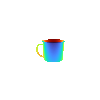

In [18]:
img = b.RENDERER.render(table_pose[None,...], jnp.array([13]))
b.get_depth_image(img[...,2]).convert("RGB")

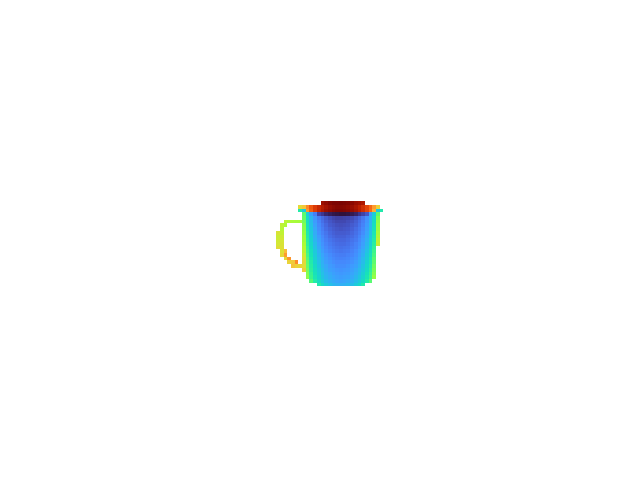

In [19]:
%matplotlib widget
fig, axes = plt.subplots()
b.add_depth_image(axes,img[...,2])
location = (37, 49)
def onclick(event):
    global location
    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))
    location = (x,y)
    print(location)
    axes.axis("on")
    axes.scatter(x,y, c='r', s=10)

fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [20]:
coordinate = img[location[1],location[0],:3]
b.clear()
b.show_cloud("data", img[:,:,:3].reshape(-1,3))
b.show_cloud("point", coordinate.reshape(-1,3), color=b.RED)
coordinate_in_object_frame = b.apply_transform(coordinate.reshape(-1,3), b.t3d.inverse_pose(table_pose))[0]
b.show_cloud("obj", b.RENDERER.meshes[IDX].vertices *5.0)
b.show_cloud("point2", coordinate_in_object_frame.reshape(-1,3) * 5.0, color=b.RED)

In [21]:
random_poses = jax.vmap(b.distributions.gaussian_vmf_jit, in_axes=(0,None, None, None))(jax.random.split(jax.random.PRNGKey(10),2000), table_pose, 0.05, 1.0)
coordinates = jnp.einsum("j,kij->ki", b.add_homogenous_ones(coordinate_in_object_frame), random_poses)
pixel_coordinates = jnp.round(b.camera.project_cloud_to_pixels(coordinates, intrinsics)).astype(jnp.int32)

images = b.RENDERER.render_many(random_poses[:,None,...], jnp.array([13]))
rendered_points = images[jnp.arange(images.shape[0]), pixel_coordinates[:,1], pixel_coordinates[:,0], :3]
distances = jnp.linalg.norm(rendered_points- coordinates[:,:3],axis=-1)
valid_indices = distances < 0.01
images_subset = images[valid_indices]
pixel_coordinates_subset = pixel_coordinates[valid_indices]


filter_size = 6
get_patch = lambda image, coordinate: jax.lax.dynamic_slice(image,
    (coordinate[1]-filter_size, coordinate[0]-filter_size, 0),
    (2*filter_size+1,2*filter_size+1,3))

patches = jax.vmap(get_patch)(images_subset, pixel_coordinates_subset)
patches_centered = patches - patches[:,filter_size,filter_size,:][...,None,None,:]

valid_indices = jnp.abs(patches_centered[:,:,2]).sum(-1).sum(-1) > 1e-4
images_subset = images_subset[valid_indices]
pixel_coordinates_subset = pixel_coordinates_subset[valid_indices]
patches_centered = patches_centered[valid_indices]

[33 67]


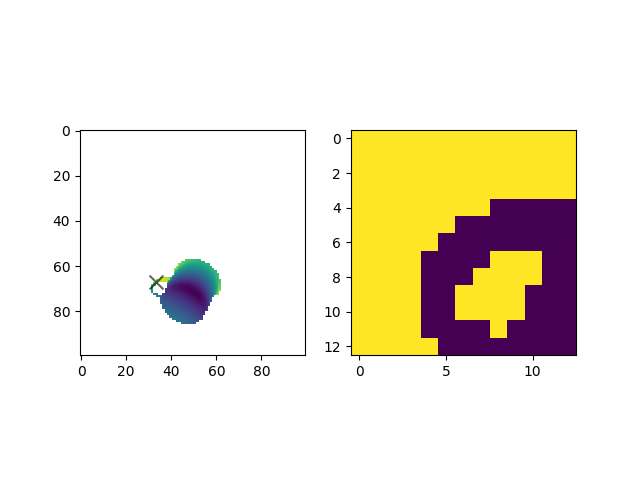

In [22]:
fig = plt.figure()
i = 1
ax = fig.add_subplot(1,2,1)
ax.imshow(b.preprocess_for_viz(images_subset[i,...,2]))
print(pixel_coordinates_subset[i,:])
ax.scatter(pixel_coordinates_subset[i,0], pixel_coordinates_subset[i,1], c='black', alpha=0.6,s=100, marker='x')
ax = fig.add_subplot(1,2,2)
b.clear()
b.show_cloud("patch_centered", patches_centered[i,...,:3].reshape(-1,3))
ax.imshow(patches_centered[i, ..., 2])

In [23]:
test_poses = jax.vmap(b.distributions.gaussian_vmf_jit, in_axes=(0,None, None, None))(jax.random.split(jax.random.PRNGKey(1000),200), table_pose,  0.05, 1.0)
test_images = b.RENDERER.render_many(test_poses[:,None,...], jnp.array([13]))
coordinates = jnp.einsum("j,kij->ki", b.add_homogenous_ones(coordinate_in_object_frame), test_poses)
pixel_coordinates = jnp.round(b.camera.project_cloud_to_pixels(coordinates, intrinsics)).astype(jnp.int32)

In [24]:
i = 1
b.clear()
b.show_cloud("1",test_images[i,...,:3].reshape(-1,3))
b.show_cloud("2",coordinates[i,...,:3].reshape(-1,3),color=b.RED)

In [35]:
def get_error_between_patches(slice_centered, patch):
    far_mask_slice_centered = (slice_centered[...,2] > 10.0)[...,None]
    far_mask_patch = (patch[...,2] > 10.0)[...,None]
    slice_centered = slice_centered * (1.0 - far_mask_slice_centered) + 1000.0 * far_mask_slice_centered
    patch = patch * (1.0 - far_mask_patch) + 1000.0 * far_mask_patch

    distances = jnp.linalg.norm(slice_centered - patch, axis=-1)
    width = 0.005
    probabilities_per_pixel = (distances > width/2)
    return probabilities_per_pixel.sum()
    
get_error_between_patches_parallel_patches = jax.vmap(get_error_between_patches, in_axes=(None, 0))

@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(1,2,),
)
def compute_error(ij, observed_xyz_padded, patch):
    slice = jax.lax.dynamic_slice(observed_xyz_padded, (ij[0], ij[1], 0), (2*filter_size + 1, 2*filter_size + 1, 3))
    slice_centered = slice - slice[filter_size, filter_size,:]
    return get_error_between_patches(slice_centered, patch)


def get_errors(observed_xyz, template):
    observed_xyz_padded = jax.lax.pad(observed_xyz,  -100.0, ((filter_size,filter_size,0,),(filter_size,filter_size,0,),(0,0,0,)))
    jj, ii = jnp.meshgrid(jnp.arange(observed_xyz.shape[1]), jnp.arange(observed_xyz.shape[0]))
    indices = jnp.stack([ii,jj],axis=-1)
    heatmap = compute_error(indices, observed_xyz_padded, template)
    return heatmap

    
get_errors_jit = jax.jit(get_errors)
get_errors_vmap_jit = jax.jit(jax.vmap(get_errors, in_axes=(None, 0)))

In [61]:
%%time
heatmaps = get_errors_vmap_jit(observed_xyz, patches_centered)[:, filter_size:-filter_size,filter_size:-filter_size]

CPU times: user 4.88 ms, sys: 189 µs, total: 5.07 ms
Wall time: 2.99 ms


(1059, 88, 88)
Best Index  (Array(281, dtype=int32), Array(11, dtype=int32), Array(49, dtype=int32))
19
49 26


Text(0.5, 1.0, 'hello')

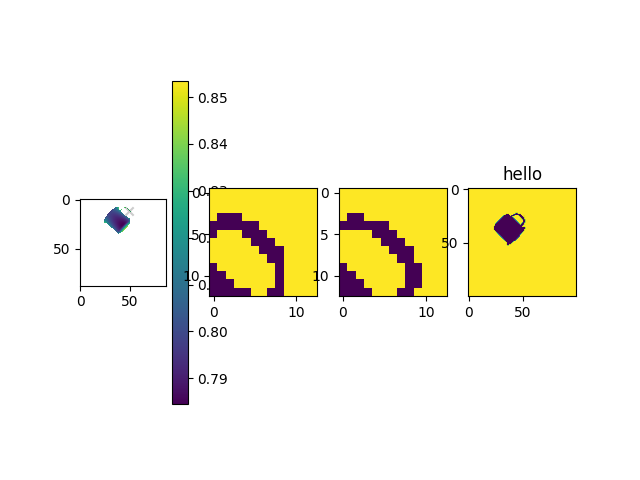

In [58]:
i = 90
observed_xyz = test_images[i,...,:3]
heatmaps = get_errors_vmap_jit(observed_xyz, patches_centered)[:, filter_size:-filter_size,filter_size:-filter_size]
print(heatmaps.shape)
# heatmaps = heatmaps.at[heatmaps < 1e-5].set(jnp.inf)
best_idx = jnp.unravel_index(heatmaps.argmin(), heatmaps.shape)

observed_patch = get_patch(
    test_images[i,...,:3],
    jnp.array([best_idx[2] + filter_size, best_idx[1] + filter_size])
)
observed_patch_centered = observed_patch - observed_patch[filter_size, filter_size,:]


print("Best Index ", best_idx)
fig = plt.figure()
ax = fig.add_subplot(1, 4, 1)
d = ax.imshow(b.preprocess_for_viz( observed_xyz[filter_size:-filter_size,filter_size:-filter_size][...,2]))
fig.colorbar(d)
ax.scatter(best_idx[2], best_idx[1],color="black", marker='x', alpha=0.2)

ax = fig.add_subplot(1, 4, 2)
ax.imshow(observed_patch_centered[...,2])


ax = fig.add_subplot(1, 4, 3)
ax.imshow(patches_centered[best_idx[0],...,2])

print(get_error_between_patches(observed_patch_centered, patches_centered[best_idx[0]]))

ax = fig.add_subplot(1, 4, 4)
ax.imshow(images_subset[best_idx[0]][...,2])
print(pixel_coordinates_subset[best_idx[0],0], pixel_coordinates_subset[best_idx[0],1])
ax.scatter(pixel_coordinates_subset[best_idx[0],0], pixel_coordinates_subset[best_idx[0],1], 
           c='black', alpha=0.05,s=10, marker='x')
ax.set_title("hello")

In [ ]:
# TODO:
#  1. Fix hack on far plane points in the template and in the slce of the observed iamge.
#  2. Make heatmap visualization. ON left is observed image. On right is red heatmap. Overlayed on image is the best match.
#  3. Make mp4 showing the heatmpas from step 2 across hundreds of test images.
# (See bayes3d/scripts/experiments/likelihood_debug/scene_parse.ipynb)